## Итоговое задание Анны Лубневской  
### по Проекту 5. Компьютер говорит «Нет» 
###  Юнит 5. Основные алгоритмы машинного обучения. Часть I 

### Описание задачи
- Обработка предоставленных данных: нахождение и заполнение пропусков, кодировка, нормализация признаков;
- Создание новых признаков с использованием предоставленных данных;
- Отбор признаков;
- Визуализация;
- Обучение и тестирование модели на полученных признаках;
- Оптимизация размера набора данных 
- Получение нового значения ROC AUC для новой модели, улучшение ее результатов на основе подбора параметра регуляризации;
- Получение предсказанных моделью значений, подготовка и отправка submission


### Импорт библиотек, установка параметров, определение функций

In [162]:
import pandas as pd
from pandas import Series
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, learning_curve 
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import re
import math
import copy
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from importlib import reload
from tqdm import tqdm
from datetime import datetime
from sklearn.linear_model import Lasso

import warnings
warnings.filterwarnings("ignore")

import os

In [163]:
# функции используемые в ноутбуке

def df_describe(df):
    desc = df.describe(include='all',percentiles=[0.5]).T
    desc['type'] = [type(x) for x in df.iloc[0]]
    desc['NaN'] = df.isna().sum()
    desc.unique = df.nunique()
    desc.top = df.mode(axis=0).iloc[0]
    desc.freq = [df[col].value_counts().iloc[0] for col in  df.columns]
    return desc

def nums_visualisation(df,annotation=False):
    columns = df.columns
    cols_num = df.shape[1]
    
    fstr = '\033[1m{}\033[0m, '* (len(columns)-1) + '\033[1m{}\033[0m'
    if annotation: print(('Всего признаков этого типа {}. К ним относятся: ' + fstr).format(len(columns),*columns))

    indent = 0.05
    fig = plt.figure(figsize=(14,3))
    for i,col in enumerate(columns):
        row = df[col]
        min_diff = pd.Series(row.unique()).sort_values().diff().min()
        bins = min(int((row.max()-row.min()) /min_diff + 1),100)
        
        fig.add_axes([1/cols_num*i, 0.35, 1/cols_num-indent, 1])
        plt.title(col)
        row.plot.hist(bins=bins,density=True)
    
        fig.add_axes([1/cols_num*i, 0, 1/cols_num-indent, 0.2])
        sns.boxplot(x=row)

    plt.tight_layout()

def num_visualisation(column,df_inp,lg=False): 
    df = df_inp.copy()
    
    if lg: df[column] = np.log(df[column]+1)
        
    hue = df.default
    trn = df[df['sample']==1]
    tst = df[df['sample']==0]
    
    row = df[column]
    row1 = trn[column][hue==0]
    row2 = trn[column][hue==1]
    
    row3 = trn[column]
    row4 = tst[column]
    
    min_diff = pd.Series(row.unique()).sort_values().diff().min()
    bins = min(int((row.max()-row.min()) /min_diff + 1),100)
    bins_range = row.min()-min_diff/2 ,row.max()+min_diff/2 

    fig = plt.figure(figsize=(14,4))
    
    ax1 = fig.add_axes([0, 0.4, 0.45, 1])
    plt.title('Распределение '+column+' в train в зависимоти от значения default' )
    row1.plot.hist(bins=bins,density=True,alpha = 0.65)
    row2.plot.hist(bins=bins,density=True,alpha = 0.65)
    plt.legend(['negative','positive'])
    
    ax2 = fig.add_axes([0, 0, 0.45, 0.30]) 
    ax1.get_shared_x_axes().join(ax1, ax2)
    sns.boxplot(data = [row1,row2],orient='h',saturation = 0.5)
    
    ax3 = fig.add_axes([0.55, 0.4, 0.45, 1])
    plt.title('Распределение '+column+' в train и test' )
    row3.plot.hist(bins=bins,density=True,alpha = 0.65)
    row4.plot.hist(bins=bins,density=True,alpha = 0.65)
    plt.legend(['train','test'])  
    
    ax4 = fig.add_axes([0.55, 0, 0.45, 0.30]) 
    ax4.get_shared_x_axes().join(ax3, ax4)
    sns.boxplot(data = [row3,row4],orient='h',saturation = 0.5)

    
def cats_visualisation(df):
    columns = df.columns
    cols_num = df.shape[1]
    
    fstr = '\033[1m{}\033[0m, '* (len(columns)-1) + '\033[1m{}\033[0m'
    print(('Всего признаков этого типа {}. К ним относятся: ' + fstr).format(len(columns),*columns))
    
    indent = 0.05
    fig = plt.figure(figsize=(14,3))
    for i,col in enumerate(columns):
        row = df[col]
        bins = df.shape[1]
        
        fig.add_axes([1/cols_num*i, 0, 1/cols_num-indent, 1])
        plt.title(col)
        sns.countplot(df[col])
    
def cat_visualisation(row):
    feat_name = row.name
    fig, axes = plt.subplots(1,2,figsize = (14,5))
    
    hue = data.default
    
    dist_1 = pd.DataFrame({'neg':row[hue==0].value_counts(normalize=True),
                           'pos':row[hue==1].value_counts(normalize=True)})
    ind = dist_1.index
    dist_2 = pd.DataFrame({'neg':data.groupby(feat_name).default.value_counts(normalize=True)[:,0],
                           'pos':data.groupby(feat_name).default.value_counts(normalize=True)[:,1]}).loc[ind]
    
    display(dist_2.T)
    dist_1.plot.bar(title = 'Распределение категорий '+ feat_name + '\n при разных значениях default',ax = axes[0])
    dist_2.plot.bar(title = 'Распределение default в каждой категории '+ feat_name,ax = axes[1],stacked=True)
    plt.legend(loc = 4)
    
def pre_process(df_inp):
    df = df_inp.copy()
    label_encoder = LabelEncoder()
    scaler = StandardScaler()    
    
    # заполнение пропусков
    df.education.fillna(df.education.mode()[0],inplace=True)
    
    df.drop(columns='app_date',inplace=True)
    
    # разделение на типы призанков
    num_uniq = df.nunique()
    bin_cols = df.columns[num_uniq==2]
    cat_cols = df.columns[(num_uniq>2) & (num_uniq<10)] 
    num_cols = df.columns[num_uniq>=10]
    
    # обработка численных признаков
    for col in num_cols.drop(['client_id','score_bki']):
        df[col] = np.log(df[col]+1)
        
    df[num_cols] = scaler.fit_transform(df[num_cols].values)
    
    # обработка категориальных признаков
    df = pd.get_dummies(df,columns=cat_cols)
    
    # отбработка бинарных признаков
    for col in bin_cols:
        df[col] = label_encoder.fit_transform(df[col])
    
    # удаление client_id
    df.drop(columns='client_id')
        
    return df

def validation(X,y,model):
    model = model
    cv_results = cross_validate(model, X, y, scoring='roc_auc', cv=5,)
    return cv_results['test_score'].mean()

In [164]:
# установка параметров
%pylab inline

pd.set_option('display.max_rows', 70) # выведем больше строк
pd.set_option('display.max_columns', 30) # выведем больше колонок

RANDOM_SEED = 42
model = LogisticRegression()

solvers_hyperparameters = {
    'newton-cg': {'penalty': ['l2'] , 
#                   'tol': logspace(-5,-3,2) ,
                  'C': logspace(-3, 3, 7) , 
                  'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] ,
                  'max_iter': [500] 
                 }, 
    'lbfgs':     {'penalty': ['l2'] , 
#                   'tol': logspace(-5,-3,2) ,
                  'C': logspace(-3, 3, 7) , 
                 'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] ,
                  'max_iter': [500] 
                 }, 
    'liblinear': {'penalty': ['l1', 'l2'] , 
#                   'tol': logspace(-5,-3,2) ,
                  'C': logspace(-3, 3, 7) , 
                  'intercept_scaling': [1,3,10,33,100],  
                 'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] 
                 },
    'sag':       {'penalty': ['l2'] , 
#                   'tol': logspace(-5,-3,2) ,
                  'C': logspace(-3, 3, 7) , 
                 'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] ,
                  'max_iter': [500] 
                 }, 
    'saga':      {'penalty': ['l1', 'l2'] , 
#                   'tol': logspace(-5,-3,2) ,
                  'C': logspace(-3, 3, 7) , 
                 'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] 
                 }
}

Populating the interactive namespace from numpy and matplotlib


### Знакомство с данными

### Описание датасета
Состоит столбцов, содержащих следующую информацию:

- **client_id** - идентификатор клиента
- **app_date** - дата подачи заявки
- **education** - уровень образования
- **sex** - пол заёмщика
- **age** - возраст заёмщика
- **car** - флаг наличия автомобиля
- **car_type**	- флаг автомобиля-иномарки
- **decline_app_cnt** - количество отказанных прошлых заявок
- **good_work** - флаг наличия «хорошей» работы
- **score_bki** - скоринговый балл по данным из БКИ
- **bki_request_cnt** - количество запросов в БКИ
- **region_rating** - рейтинг региона
- **home_address** - категоризатор домашнего адреса
- **work_address** - категоризатор рабочего адреса
- **income** - доход заёмщика
- **sna** - связь заемщика с клиентами банка
- **first_time** - давность наличия информации о заемщике
- **foreign_passport** - наличие загранпаспорта
- **sample**
- **default** - наличие дефолта (целевая переменная)

In [165]:
sample_submission = pd.read_csv('data/sample_submission.csv')
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')

Для корректной работы с признаками объединим train и test в один датасет data

In [166]:
train['sample'] = 1  # помечаем где у нас train
test['sample'] = 0   # помечаем где у нас test
test['default'] = 0  # в test нет значения default, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [167]:
# Проверим наличие дупликатов
data.duplicated().sum()

0

In [168]:
# посмотрим на данные

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [169]:
data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Columns: 20 entries, client_id to default
dtypes: float64(1), int64(13), object(6)
memory usage: 16.8+ MB


In [170]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


In [171]:
display(df_describe(data))

,count,unique,top,freq,mean,std,min,50%,max,type,NaN
client_id,110148,110148,1,1,55074.5,31797.1,1,55074.5,110148,<class 'numpy.int64'>,0
app_date,110148,120,18MAR2014,1491,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
education,109670,5,SCH,57998,NaN,NaN,NaN,NaN,NaN,<class 'str'>,478
sex,110148,2,F,61836,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
age,110148,52,31,4084,39.2494,11.5181,21,37,72,<class 'numpy.int64'>,0
car,110148,2,N,74290,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
car_type,110148,2,N,89140,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
decline_app_cnt,110148,24,0,91471,0.273205,0.799099,0,0,33,<class 'numpy.int64'>,0
good_work,110148,2,0,91917,0.165514,0.371645,0,0,1,<class 'numpy.int64'>,0
score_bki,110148,102618,-1.77526,517,-1.90454,0.499397,-3.62459,-1.92082,0.199773,<class 'numpy.float64'>,0


Как видиим 14 признаков представлены числовым типом данных, 6 строковыми величинами. Из этих 6 "строковых" признаков 4 признака бинарных, один категориальный(5 уникальных значений, одно из них NaN) и один,`app_date`- временной ряд.  

Пропуски встречаются только в одном признаке `education`. Их количество не велико и составляет менее 0,5% от количества наблюдений.  

Сравнивая количество уникальных значений *unique* и частоту  наиболее часто встречающейся категории *freq* можно заметь несбалансированность признаков по категориям. В `foreign_passport` `good_work` `decline_app_cnt` и `default` доля дисбаланса составляет около 6/7, что особенно в целевой переменной `default` может создать проблемы при обучении модели. Нам придется предпринимать меры для устранения несбалансированности.

Посмотрим на данные:

In [172]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
45861,74938,22MAR2014,UGR,F,21,N,N,0,0,-2.029458,0,60,2,3,32000,2,1,N,1,0
93180,22560,29JAN2014,SCH,F,36,N,N,0,0,-1.190065,5,40,2,2,27000,1,3,N,1,0
45269,73903,21MAR2014,SCH,F,24,N,N,0,0,-1.591405,2,60,1,2,12500,1,2,N,1,0
47113,20644,28JAN2014,SCH,M,26,Y,N,0,0,-2.253374,2,50,2,2,20000,2,3,N,1,0
85221,50322,27FEB2014,SCH,M,38,N,N,1,0,-1.868492,0,50,1,2,30000,1,4,N,1,0


Предлагаю на этом этапе разделить признаки на количественные `num_cols` , категориальные `cat_cols` и бинарные `bin_cols`.
Временной ряд рассмотрим отдельно.

In [173]:
num_uniq = train.nunique()
time_col = pd.Index(['app_date'])
bin_cols = train.columns[num_uniq==2]
cat_cols = train.columns[(num_uniq>2) & (num_uniq<10)] 
num_cols = train.columns[num_uniq>=10].drop(time_col)

### Работа с данными
Сперва рассмотрим существующие признаки, разделив их по типам. Выберем способы предобработки, извлечем, если возможно, из существующих признаков информацию для создания новых. Затем предобработаем существующие признаки согласно выбранным способам. После этого создадим новые, при необходимости предобработаем и их тоже.


### Временной признак

Временной признак у нас в строковом виде. Приведем его к типу `Datetime`. Затем сразу на этой стадии извлечем из него  признаки `app_day_num`, `app_weekday`, `day`, `app_day_weekend`  и `app_month_beginning` - возможно, они понадобятся нам при работе в дальнейшем. После чего удалим исходный `app_date`.

In [174]:
from datetime import datetime

data.app_date = pd.to_datetime(data.app_date,format='%d%b%Y')

data['app_day_num'] = (data.app_date - data.app_date.min()).dt.days  # день подачи заявки от начала ведения БД
data['app_weekday'] = data.app_date.dt.weekday                       # день недели подачи заявки
data['day'] = data.app_date.dt.day                                   # число подачи заявки
data['app_day_weekend'] = data.app_date.dt.weekday.ge(5).astype(int) # день подачи заявки - выходной
data['app_month_beginning'] = data.app_date.dt.day.le(7).astype(int) # подача заявки в первые 7 дней месяца

# data.drop(columns='app_date',inplace=True)

Посмотрим на распределения полученных признаков

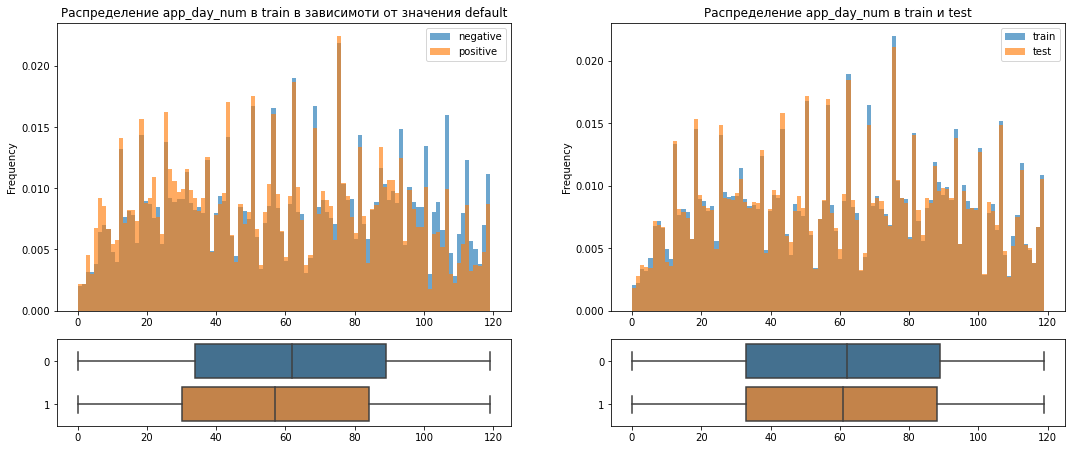

In [175]:
num_visualisation('app_day_num',data)

На графике распределений `app_day_num` в обучающей части выборки заметен сдвиг влево. Со временем доля дефолтов падает. Обьяснения тому могут быть разные: банк настроил систему скоринга или , например, более поздние клиенты еще не успели показать свои возможности.  

На графике распределений `app_day_num` на обучающей и тестовой части выборки заметна маленькая разница - медиана и 3 квартиль на тестовой части немного меньше. Разница небольшая, но есть. Если такая картина повторится во других признаках, то будет смысл провести нормирование выборки.

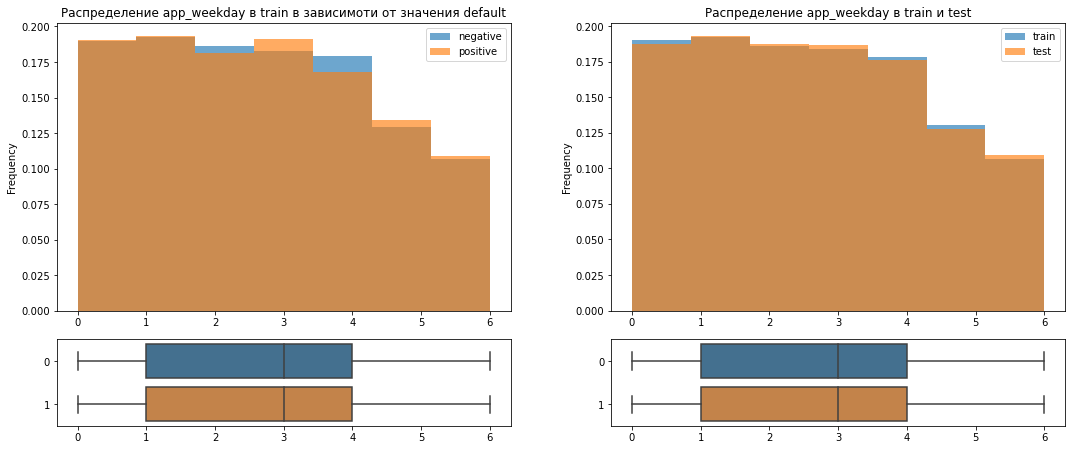

In [176]:
num_visualisation('app_weekday',data)

,0,1,2,3,4,5,6
neg,0.914436,0.914686,0.917013,0.912003,0.919338,0.911654,0.914148
pos,0.085564,0.085314,0.082987,0.087997,0.080662,0.088346,0.085852


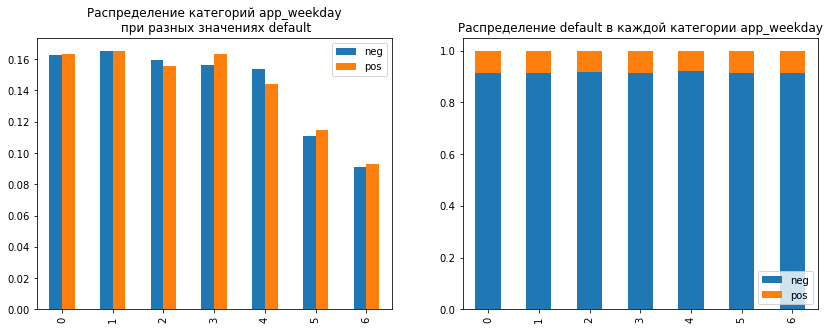

In [177]:
cat_visualisation(data[data['sample']==1].app_weekday)

У дефолтных клиетов четверг и выходные дни чуть более популярны для подачи заявки, чем у платежеспособных.

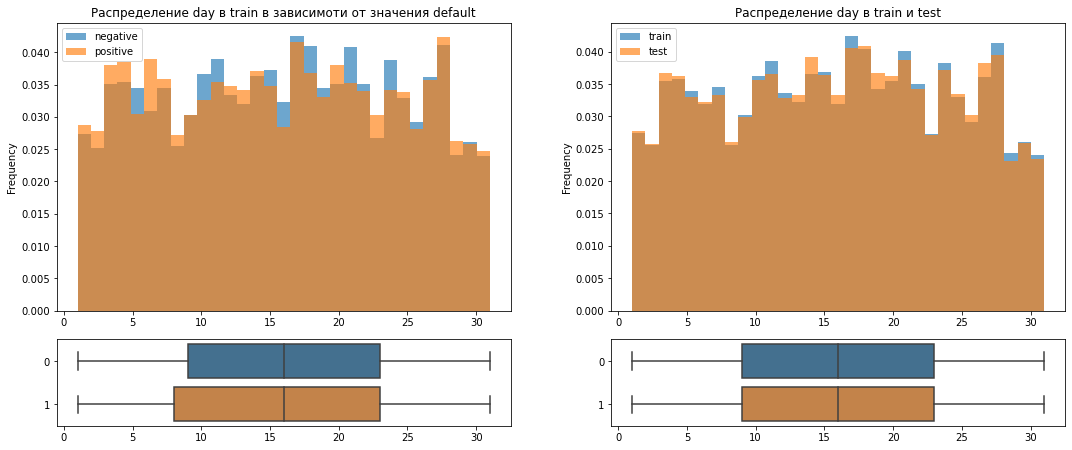

In [178]:
num_visualisation('day',data)

В этом признаке распределние дефолта немного сдвинуто влево. Вероятно, клиенты со склонностью к дефолту подают заявку на кредит в начале месяца, а клиенты платежеспособныые несколько позже. Разницы в распределении признака в обучающей и тестовой части нет (не заметна).

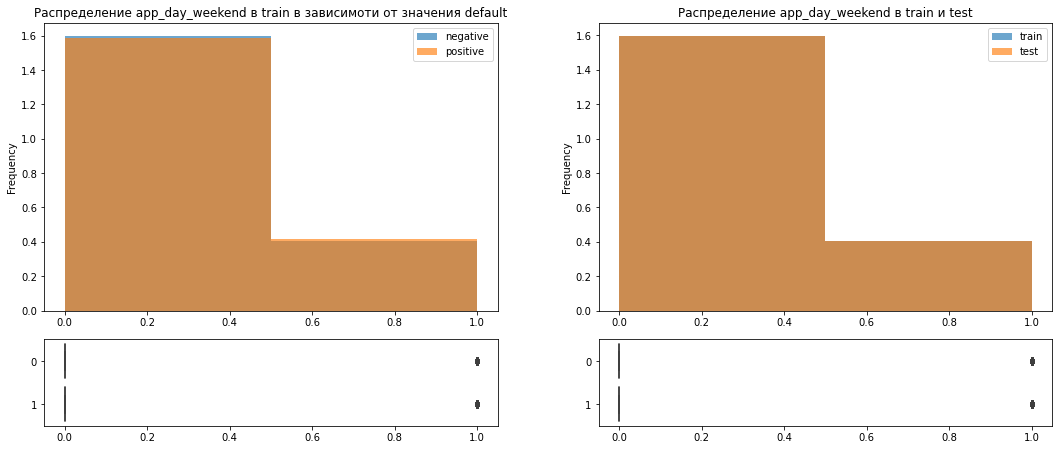

In [179]:
num_visualisation('app_day_weekend',data)

,0,1
neg,0.915456,0.912787
pos,0.084544,0.087213


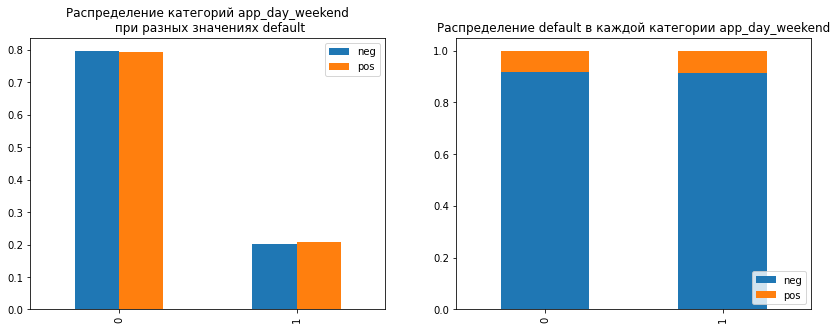

In [180]:
cat_visualisation(data[data['sample']==1].app_day_weekend)

Заметить можно лишь небольшое повышение популярности выходных дней для подачи заявки среди дефолтных клиентов. Возможно, они наемные рабочие, и не имеют возможности обращаться в банк в рабочее вермя будних дней.

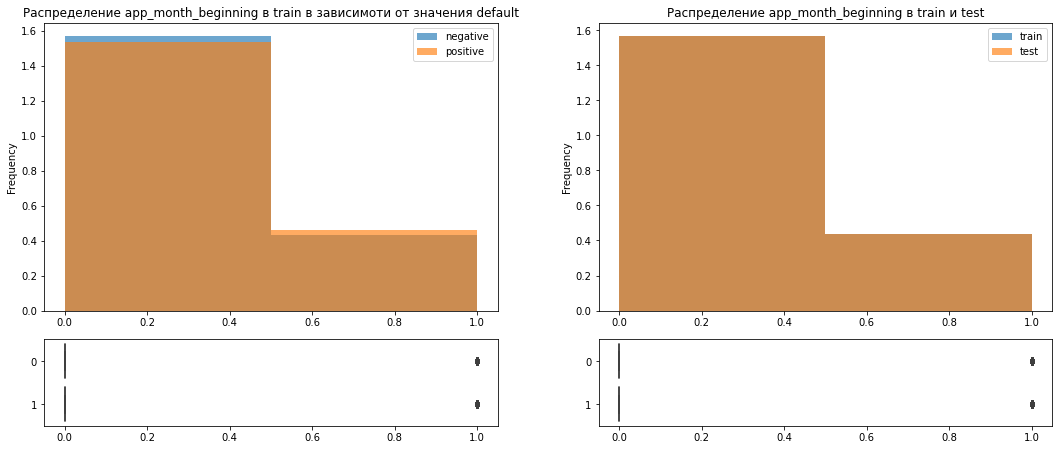

In [181]:
num_visualisation('app_month_beginning',data)

,0,1
neg,0.91635,0.909751
pos,0.08365,0.090249


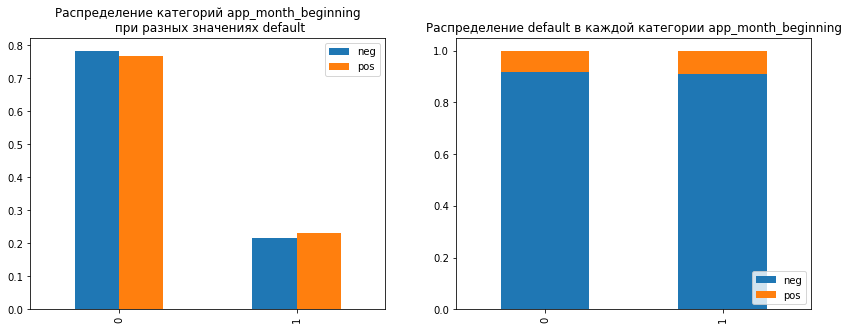

In [182]:
cat_visualisation(data[data['sample']==1].app_month_beginning)

Распределине похоже на предыдущие варинаты. Дефолтные клиенты с небольшой разницей подают заявки в начале месяца. 

In [183]:
# Удостоверимся, что все клиенты обращались в 2014 году
data.app_date.dt.year.value_counts()

2014    110148
Name: app_date, dtype: int64

In [184]:
data.app_date.dt.month.value_counts()

3    31597
2    27097
4    26266
1    25188
Name: app_date, dtype: int64

Кроме того, видим, что клиенты обращались с января по апрель

In [185]:
# Выясняем начало и конец периода нашего датасета - это 1 января и 30 апреля 2014 года
start = data.app_date.min()
end = data.app_date.max()
start,end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

### Количественные признаки
Начнем с общего обзора, потом перейдем к признакам в отдельности. 

Всего признаков этого типа 6. К ним относятся: client_id, age, decline_app_cnt, score_bki, bki_request_cnt, income


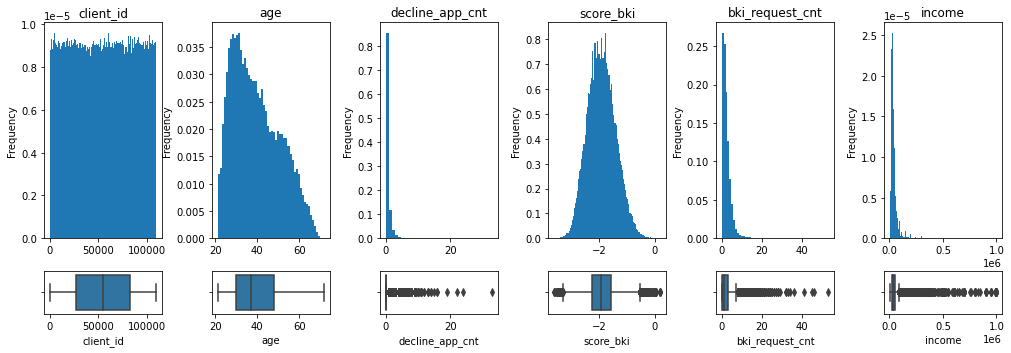

In [186]:
nums_visualisation(train[num_cols], annotation=True)

Кроме client_id и score_bki, признаки не имеютнормального распределения, а склонны к смещению вправо. Применим логарифмирование:

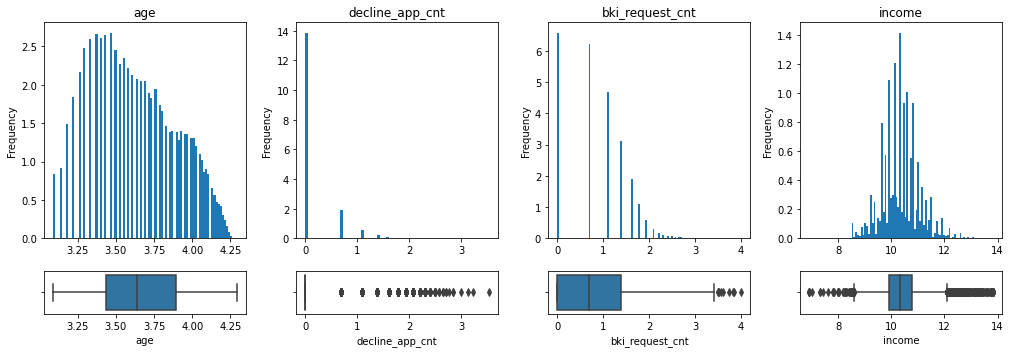

In [187]:
nums_visualisation(np.log(train[num_cols.drop(['client_id','score_bki'])]+1))

### age

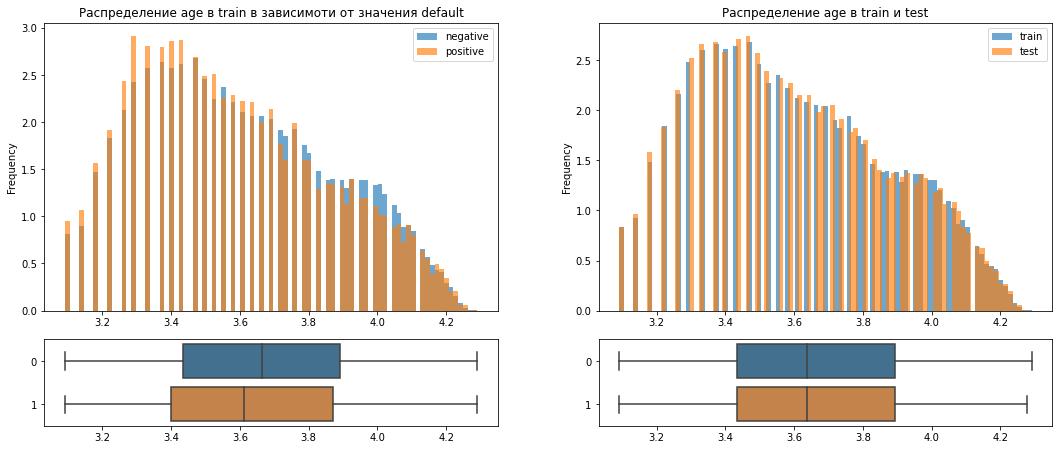

In [188]:
num_visualisation('age',data,lg=True)

Дефолтные клиенты более молодые. Разница в распределении признака в обучающей и тестовой части незаметна

### decline_app_cnt
Количество отказанных прошлых заявок

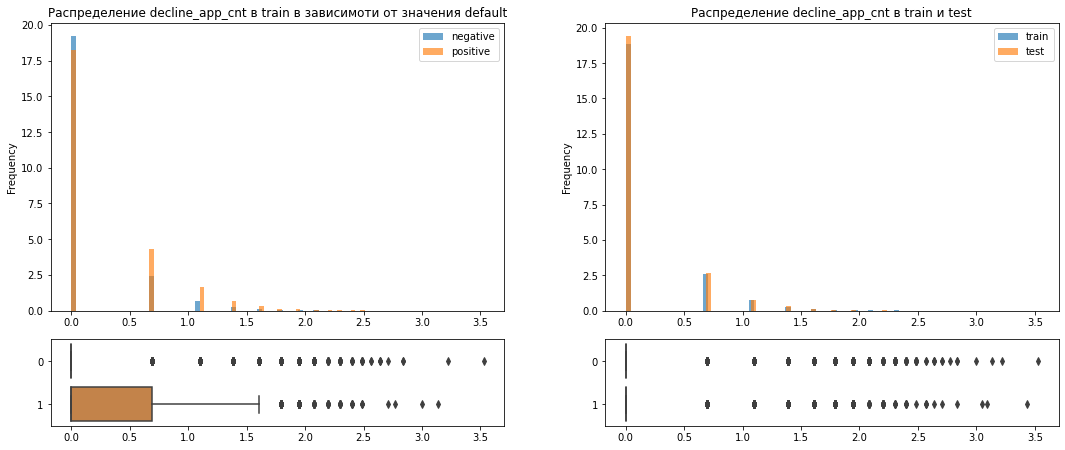

In [189]:
num_visualisation('decline_app_cnt',data,lg=True)

Количество отказов дефолтным клиентам выше, чем платежеспсосбным. 

In [190]:
#добавим признак с логарифмом 
data['decline_app_cnt_log']=np.log(data['decline_app_cnt']+1)

### score_bki
Скоринговый балл по данным из БКИ

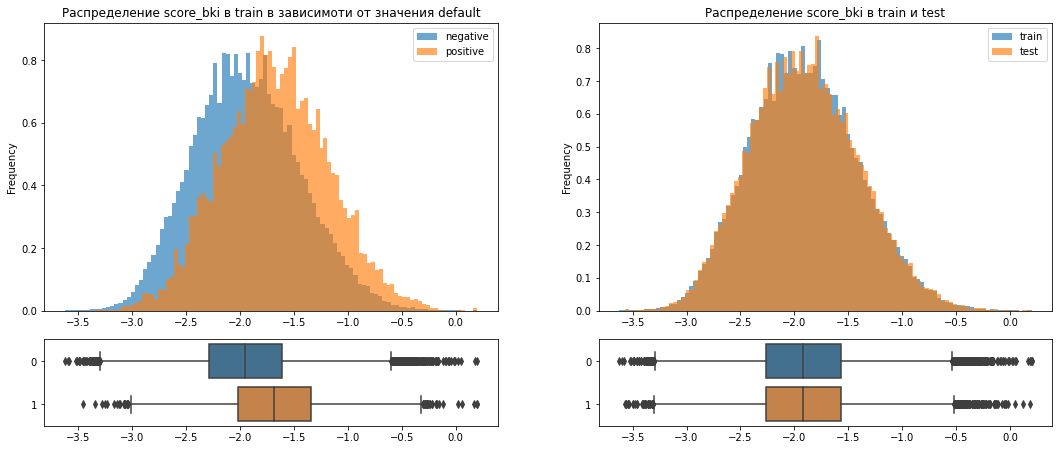

In [191]:
num_visualisation('score_bki',data)

Сильная разница баллов в распределениях дефолтных и платежеспопосбных клиентов. Признак полезный. Различия в распределении в обучающей и тестовой части не видно.

### bki_request_cnt
Количество запросов в БКИ

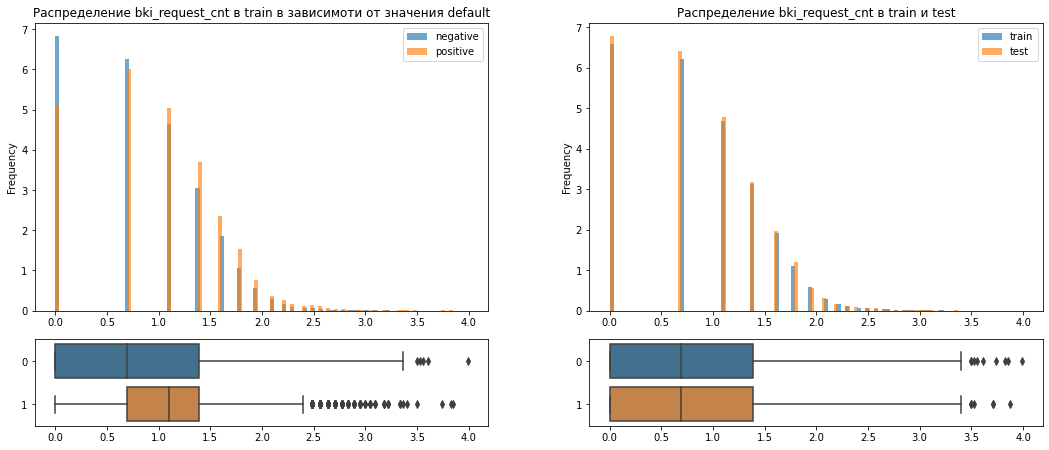

In [192]:
num_visualisation('bki_request_cnt',data,lg=True)

Распределение похоже на распределение Пуассона. У дефолтных среднее количество запросов выше. Возможно, они чаще пытаются получить кредит или рассрочку. Значительная разница в распределениях в обучающей и тестовой части отсутсвует.

In [193]:
#добавим признак с логарифмом 
data['bki_request_cnt_log']=np.log(data['bki_request_cnt']+1)

### income
Доход клиента-заемщика

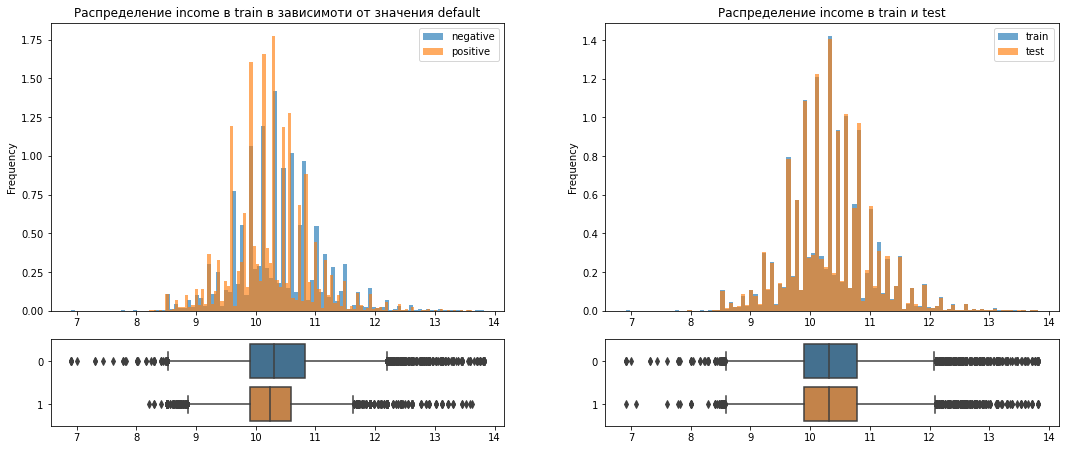

In [194]:
num_visualisation('income',data,lg=True)

Любопытный результат. Доходы дефолтных клиентов ниже, к тому же меньше разброс их доходов. Что самое интересное -наиболее низкие доходы как раз у платежеспособных. Как вариант, они не показывают свои реальные доходы. Или клиентам с минимальными доходами не дают кредит, а это в свою очередь результат отсутствия дефолта.  
Разница между обучающей и тестовой выборкой отсутствует.

In [195]:
#добавим признак с логарифмом 
data['income_log']=np.log(data['income']+1)

In [196]:
data.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_day_num,app_weekday,day,app_day_weekend,app_month_beginning,decline_app_cnt_log,bki_request_cnt_log,income_log
0,74835,2014-03-22,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0,80,5,22,1,0,0.000000,1.386294,10.819798
1,17527,2014-01-24,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0,23,4,24,0,0,1.791759,1.098612,8.517393
2,75683,2014-03-23,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0,81,6,23,1,0,0.000000,0.693147,10.308986


### Категориальные признаки
Начнем с общего обзора, потом перейдем к каждому признаку в отдельности. 

Всего признаков этого типа 6. К ним относятся: education, region_rating, home_address, work_address, sna, first_time


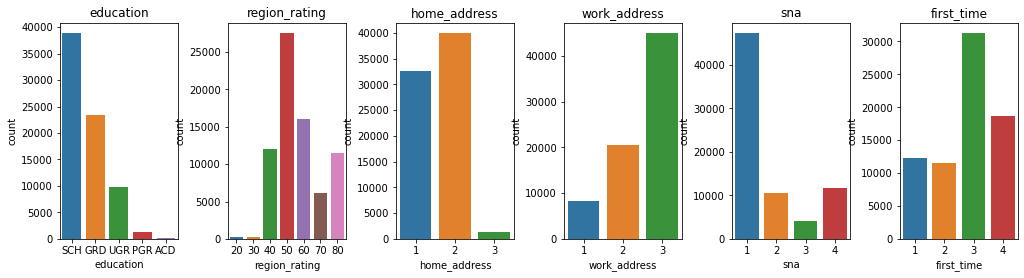

In [197]:
cats_visualisation(train[cat_cols]) 

### education


,SCH,GRD,UGR,PGR,ACD
neg,0.8991,0.939456,0.912463,0.956568,0.972509
pos,0.1009,0.060544,0.087537,0.043432,0.027491


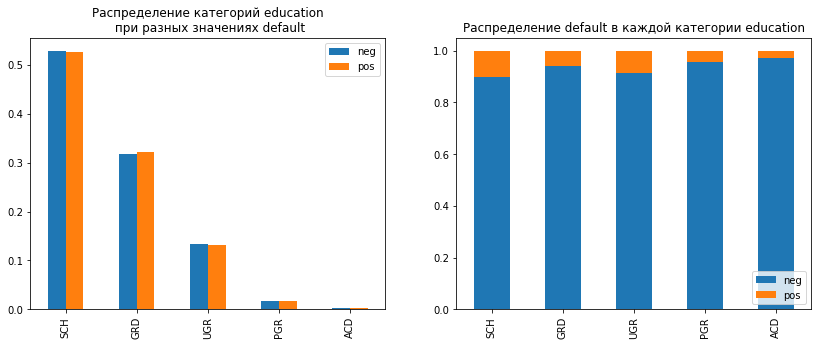

In [198]:
cat_visualisation(train.education)

Судя по результату, уровень образования напрямую влияет на финансовые опказатели. Возможно, это связано с финансовой дисциплиной, возможно, изначально решения более взвешенные. Самые ненадежные заемщики те, кто еще учится, далее окончившие школу. Более надежными становятся заемщики, получающие высшее образование, самые надежныете, кто получил ученую степень.

### region_rating
Рейтинг региона

,50,60,40,80,70,30,20
neg,0.908567,0.913705,0.886276,0.951136,0.938414,0.868664,0.859425
pos,0.091433,0.086295,0.113724,0.048864,0.061586,0.131336,0.140575


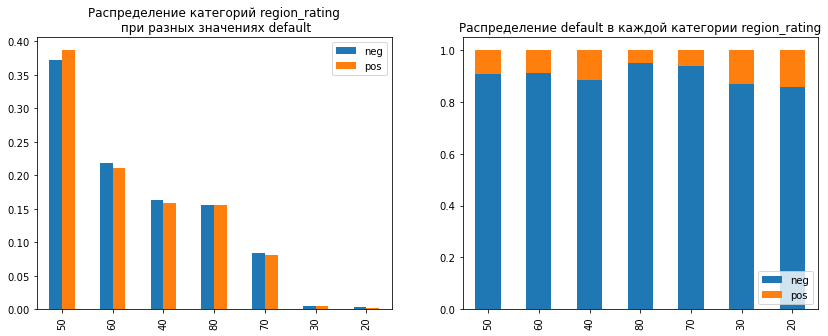

In [199]:
cat_visualisation(train.region_rating)

Рейтинг региона прямо связан с надежностью замщика - чем выше рейтинг района, тем меньше дефолтных клиентов.

### home_address


,2,1,3
neg,0.895974,0.937829,0.921883
pos,0.104026,0.062171,0.078117


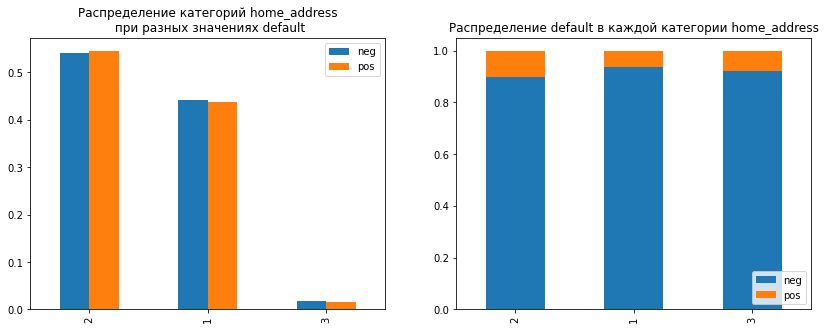

In [200]:
cat_visualisation(train.home_address)

Доминируют две категории - 1 и 2. В этих двух категориях разница в долях дефолтных клиентов небольшая, но есть. Вероятно, признак будет полезным.

### work_address

,3,2,1
neg,0.900884,0.931667,0.94965
pos,0.099116,0.068333,0.05035


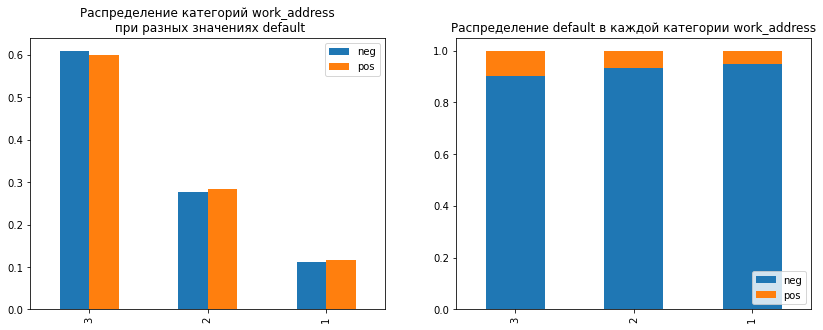

In [201]:
cat_visualisation(train.work_address)

Доля дефолтных клиенов в самой популярной категории 3 отличается от такой доли в других категориях. Данный признак так же, вероятно, будет полезны.

### sna 
Связь заемщика с клиентами банка

,1,4,2,3
neg,0.934282,0.857846,0.899444,0.894378
pos,0.065718,0.142154,0.100556,0.105622


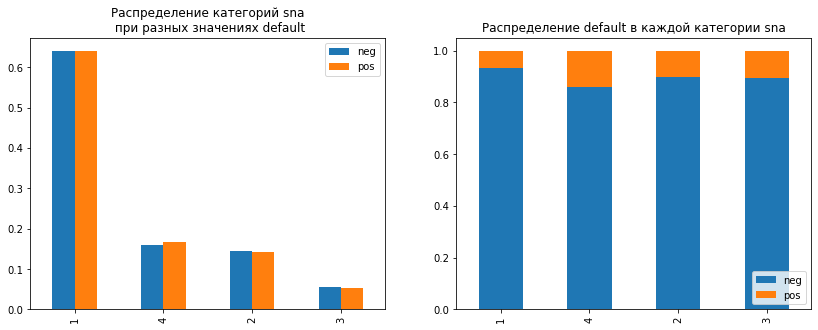

In [202]:
cat_visualisation(train.sna)

Так же есть категория 1, которая сильно отличается долей дефолтных клиентов.

### first_time
Давность наличия информации о заемщике

,3,4,1,2
neg,0.919314,0.94514,0.875492,0.89575
pos,0.080686,0.05486,0.124508,0.10425


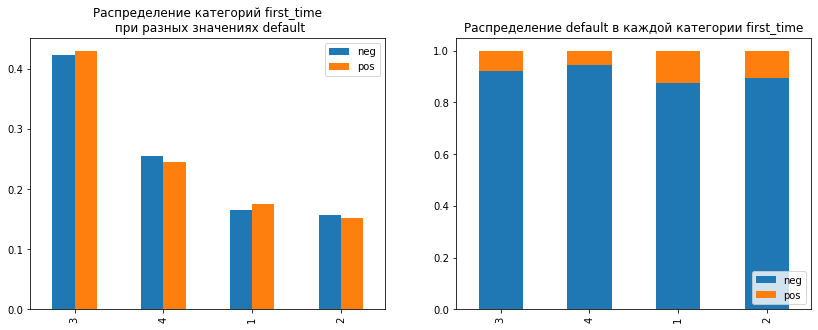

In [203]:
cat_visualisation(train.first_time)

Судя по результату, есть зависимость между давностью появления клиента в базе и долей дефолтных клиентов.

### Бинарные признаки
Начнем с общего обзора, потом перейдем к каждому признаку в отдельности.

Всего признаков этого типа 6. К ним относятся: sex, car, car_type, good_work, foreign_passport, default


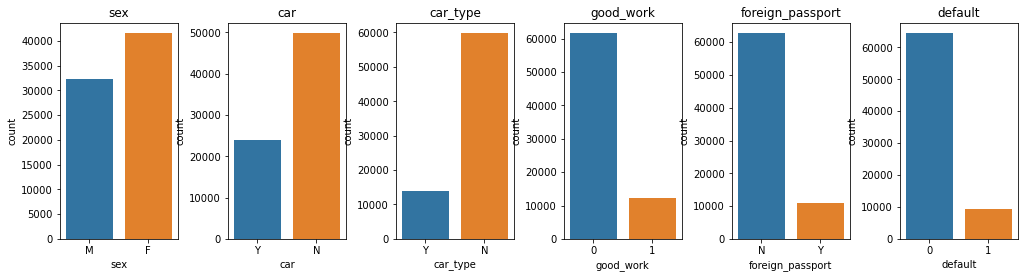

In [204]:
cats_visualisation(train[bin_cols]) 

### sex

,F,M
neg,0.91851,0.910312
pos,0.08149,0.089688


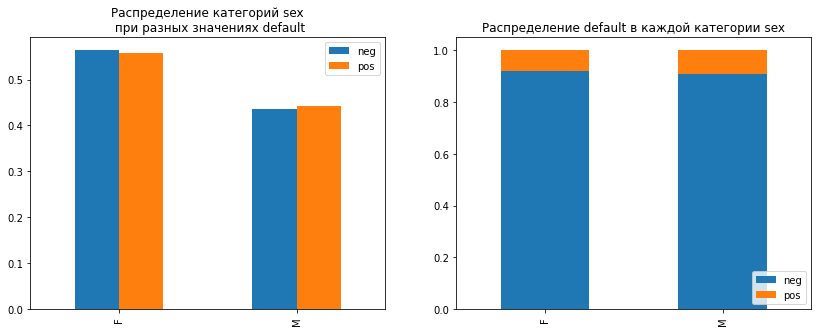

In [205]:
cat_visualisation(train.sex)

Мужчины чаще женщин попадают в дефолтную группу

### car
Наличие автомобиля

,N,Y
neg,0.90813,0.92897
pos,0.09187,0.07103


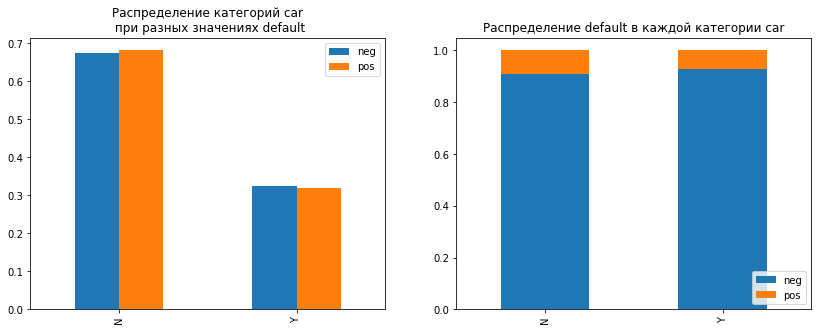

In [206]:
cat_visualisation(train.car)

Заемщики, у которых есть машина, более дисциплинированы в финансовых вопросах

### car_type
Автомобиль иномарка

,N,Y
neg,0.908604,0.941689
pos,0.091396,0.058311


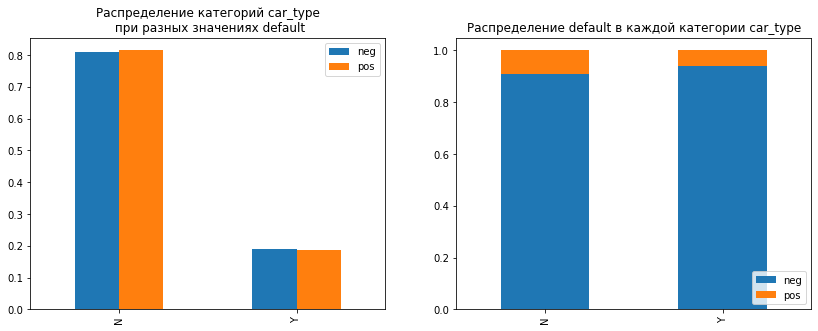

In [207]:
cat_visualisation(train.car_type)

Заемщики с иномаркой чуть менее финансово дисциплинированы. Интересное наблюдение. Возможно, это связано с тем, что более люксовая машина также приобретена с привлечением заемных средств,что может оказывать влияние на дальнейшие выплаты по заемному долгу.

### good_work
Наличие "хорошей" работы

,0,1
neg,0.91055,0.936921
pos,0.08945,0.063079


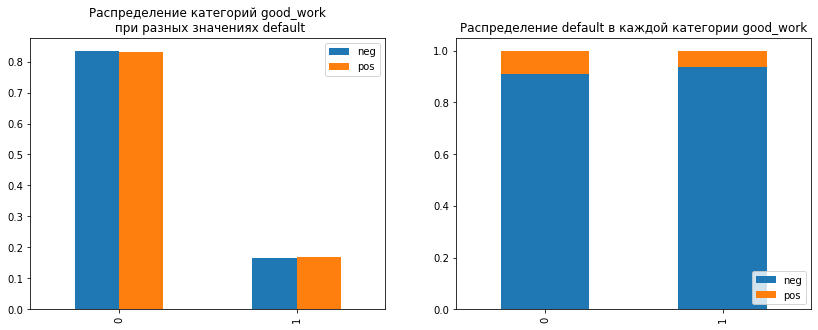

In [208]:
cat_visualisation(train.good_work)

Прямая зависимость наличия хорошей  работы и финансовой безопасности как для заемщика, так и для банка.

### foreign_passport
Наличие загранпаспорта

,N,Y
neg,0.90875,0.950082
pos,0.09125,0.049918


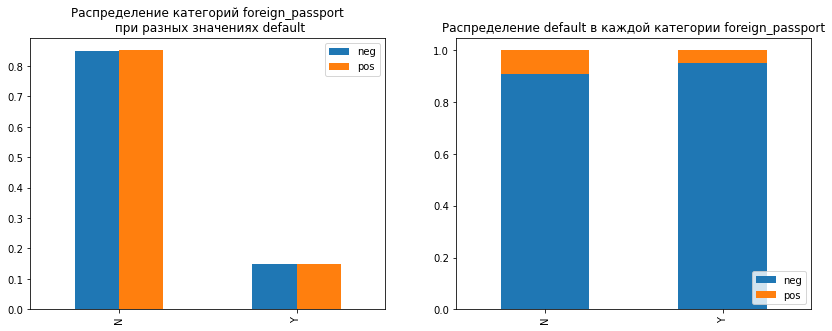

In [209]:
cat_visualisation(train.foreign_passport)

Наличие загранпаспорта подтверждает более высокую финансовую стабильность клиента. Возможность выезжать за границу связана либо с более высокими доходами, либо с возможными командировками, что тоже может говорить и о хорошей работе, и хорошей занимаемой должности.

### Предобработка

In [210]:
X = pre_process(data.drop(columns='default'))

### Baseline
Обучим на подготовленных данных модель `LogisticRegression()` с параметрами по умолчанию и получим значение метрики. Будем рассматривать эту модель как первую итерацию, первое приближение которой нужно улучшить.

In [211]:
X_train = X[X['sample']==1].drop(columns='sample')
y_train = train.default
validation(X_train, y_train, LogisticRegression())

0.7340966133200382

### Определение оптимального размера набора данных
Далее при отборе признаков и при подборе гиперпараметров нам предстоит многократное обучение модели на обучающей выборке. Для того чтобы оптимизировать процесс, проверим зависимость метрики от размера выборки, возможно, начиная с некоторого момента рост размера обучающей выборки перестает ощутимо влиять на качество модели, и мы сможем произвести подбор гиперпараметров, используя оптимизированный набор данных.



In [212]:
cv = StratifiedKFold(n_splits=5,random_state=RANDOM_SEED)

_, _, test_scores = learning_curve(
       model, X_train, y_train, train_sizes=np.linspace(.1, 1.0, 19), cv=cv, scoring = 'roc_auc')

Визуализируем полученный результат

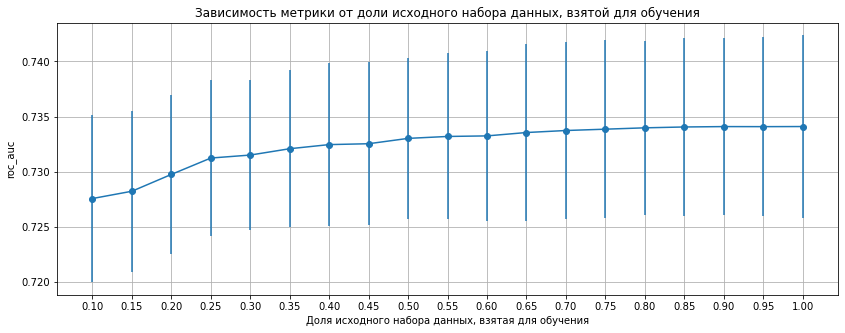

In [213]:
train_prop = np.linspace(.1, 1.0, 19)

test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

plt.figure(figsize=(14,5))
plt.grid(True)
plt.xticks(train_prop)
plt.errorbar(train_prop, test_scores_mean , yerr = test_scores_std, fmt='o-')

plt.title('Зависимость метрики от доли исходного набора данных, взятой для обучения')
plt.ylabel('roc_auc')
plt.xlabel("Доля исходного набора данных, взятая для обучения");

Рост постепенно приостанавливается при значениях 0.75. 

### Feature engineering - добавление новых признаков

In [214]:
# Бинарный признак не нулевого количества запросов в БКИ
data['bki_req_exist'] = (data.bki_request_cnt!=0).astype(int)

# Бинарный признак не нулевого количества отказов
data['decline_app_cnt_exist'] = (data.decline_app_cnt==0).astype(int)

# Бинарный признак нахождения клиента в одном из трех кластеров по времени обращения
data['claster_1'] = data.client_id.lt(10000).astype(int)
data['claster_2'] = data.client_id.between(10000,90000).astype(int)
data['claster_3'] = data.client_id.gt(90000).astype(int)

# Отношение количества запросов в БКИ ко времени внесения клиента в базу 
data['pry'] = np.log(data.bki_request_cnt/data.client_id +1)

# Отношение количества отказов ко времени существоваия клиента в базе
data['persistence'] = np.log(data.decline_app_cnt/data.client_id +1)

# отношение отказов к возрасту 
data['unreliability'] = np.log(data.decline_app_cnt/data.age +1)

# отношение дохода к возрасту 
data['incom_career'] = np.log((data.income/data.age)+1)

# отношение ранга образования к возрасту 
edu_dict = {'SCH': 1,'UGR': 2,'GRD': 3,'PGR': 4,'ACD': 5}
edu = data.education.fillna(data.education.mode()[0]).map(edu_dict)
data['edu_career'] = np.log((edu/data.age)+1)

# успешность клиента, основанная на наличии авто, иномарки, загранпаспорта и хорошей работы
success_car = np.array([2 if x=='Y' else 1  for x in data.car])
success_import_car = np.array([2 if x=='Y' else 1  for x in data.car_type])
success_passport =  np.array([2 if x=='Y' else 1  for x in data.foreign_passport])
success_work = np.array([2 if x=='Y' else 1  for x in data.good_work])
data['success'] = success_car*success_import_car*success_passport*success_work

Посмотрим,  как изменилось качество предсказания на обогащенном наборе данных

In [215]:
X_enrich = pre_process(data.drop(columns='default'))
y_train = train.default

X_enrich_train = X_enrich[X_enrich['sample']==1].drop(columns='sample')

print(validation(X_enrich_train, y_train, LogisticRegression()))

0.7356969898843555


In [216]:
# Оптимизированные 
X_enrich_train_opt, _, y_train_opt, _ = train_test_split(
    X_enrich_train, y_train, train_size=0.75, stratify=y_train, random_state=RANDOM_SEED)            

print(validation(X_enrich_train_opt, y_train_opt, LogisticRegression()))

0.7350935998744577


### Отбор признаков
Попробуем отбросить признаки, которые не совсем полезны для модели. Используем Lasso. Обучим модель на обогащенном по признакам и оптимизированном по количеству наблюдений наборе данных.

In [217]:
selector = Lasso(alpha=0.0001)
selector.fit(X_enrich_train_opt,y_train_opt)

Lasso(alpha=0.0001)

Получим список наименее полезных с точки зрения модели признков

In [218]:
sorted_by_Lasso = abs(pd.Series(selector.coef_,index = X_enrich_train.columns)).sort_values()
unuseful_features_LR = sorted_by_Lasso[sorted_by_Lasso<0.01].index

Вместо того, что бы просто удалить все неполезные признаки, станем удалять их по одному, начиная с  самого неполезного. И при этом будем следить за изменением метрики и остановимся на том количестве удаляемых признаков при котором изменение метрики будет наиболее выгодным.

In [145]:
model = LogisticRegression(random_state=RANDOM_SEED)
metrics_changes = pd.Series()

for loc in tqdm(range(0,len(unuseful_features_LR),1)):
    to_drop = unuseful_features_LR[:loc] 
    X_tmp = X_enrich_train_opt.drop(columns=to_drop)
    metrics_tmp = validation(X_tmp,y_train_opt,model)
    metrics_changes.loc[loc] = metrics_tmp

100%|██████████| 39/39 [01:23<00:00,  2.15s/it]


### Подбор гиперпараметров
Используем для поиска парметров **sklearn.model_selection.RandomizedSearchCV**. Этот подход позволяет обойтись меньшимим ресурсами, по сравнению с ***GridSearchCV***.

In [221]:
%%time
n_iter = 75
search = pd.Series()

for solver in solvers_hyperparameters:
    hyperparameters = solvers_hyperparameters[solver]
    model = LogisticRegression(solver=solver, random_state=RANDOM_SEED)
    clf = RandomizedSearchCV(model, hyperparameters, n_iter=n_iter, scoring='roc_auc', cv=5, random_state=RANDOM_SEED)
    search[solver] = clf.fit(X_enrich_train_opt_select, y_train_opt)

CPU times: user 13min 37s, sys: 2min 6s, total: 15min 43s
Wall time: 11min 9s


Посмотрим на метрику выбранной модели.

In [222]:
fin_solver = search.apply(lambda x: x.best_score_).idxmax()
fin_params = search[fin_solver].best_params_
fin_solver, search[fin_solver].best_score_, fin_params

('newton-cg',
 0.7361074414664281,
 {'penalty': 'l2', 'max_iter': 500, 'class_weight': {0: 1, 1: 7}, 'C': 0.1})

Определим окончательную модель.

In [223]:
fin_model = search[fin_solver].best_estimator_

Проведем валидацию этой модели:

In [224]:
X_enrich_select_train = X_enrich_select[X_enrich_select['sample']==1].drop(columns='sample')
validation(X_enrich_select_train, y_train, fin_model)

0.7362977616938123

### Submission
Обучим модель на полной обучающей выборке

In [225]:
fin_model.fit(X_enrich_select_train,y_train)

LogisticRegression(C=0.1, class_weight={0: 1, 1: 7}, max_iter=500,
                   random_state=42, solver='newton-cg')

Отделим от объедененного датасета валидационную часть и получим на ней предсказание целевой переменной:

In [226]:
X_enrich_select_test = X_enrich_select[X_enrich_select['sample']==0].drop(columns='sample')

pred = fin_model.predict_proba(X_enrich_select_test)[:,1]

Сформируем и отправим submission:

In [227]:
submission = pd.DataFrame(dict(client_id = test.client_id,default = pred))

submission.to_csv('submission.csv', index=False)

**ИТОГИ:**

Итоговая метрика на kaggle - 0.73812  
Вошла в Top 16%